# Transformer

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from skimage import io
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Set Directories

In [2]:
from data_loader.biosr_dataset import BioSRDataset

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Load Data

In [3]:
# Instantiate the dataset
resize_to_shape = (128,128)
dataset = BioSRDataset(root_dir=data_dir, resize_to_shape=resize_to_shape)

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each set
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Check dataset length
print(f"Dataset length: {len(dataset)}")

# Check a single sample
sample = dataset[1] 
print(f"Sample 1 image shape: {sample[0].shape}")
print(f"Sample 2 image shape: {sample[1].shape}")

height = sample[0].shape[0]
width = sample[0].shape[1]

# Create DataLoader for each split
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


# Example of iterating over the DataLoader
for batch in train_loader:
    inputs, targets = batch
    # Process your images
    print(f"Batch inputs shape: {inputs.shape}")
    print(f"Batch targets shape: {targets.shape}") 


Resizing to shape (128, 128). MUST BE REMOVED IN PRODUCTION!
c1_data shape: (128, 128, 68)
c2_data shape: (128, 128, 54)
Dataset length: 54
Sample 1 image shape: (128, 128)
Sample 2 image shape: (2, 128, 128)
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: torch.Size([4, 128, 128])
Batch targets shape: torch.Size([4, 2, 128, 128])
Batch inputs shape: tor

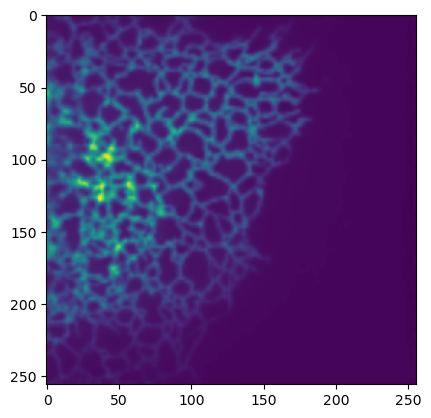

In [4]:
from skimage.transform import resize
plt.imshow(resize(dataset.c1_data, (256,256, dataset.c1_data.shape[-1]))[...,0])

## Visualize Data

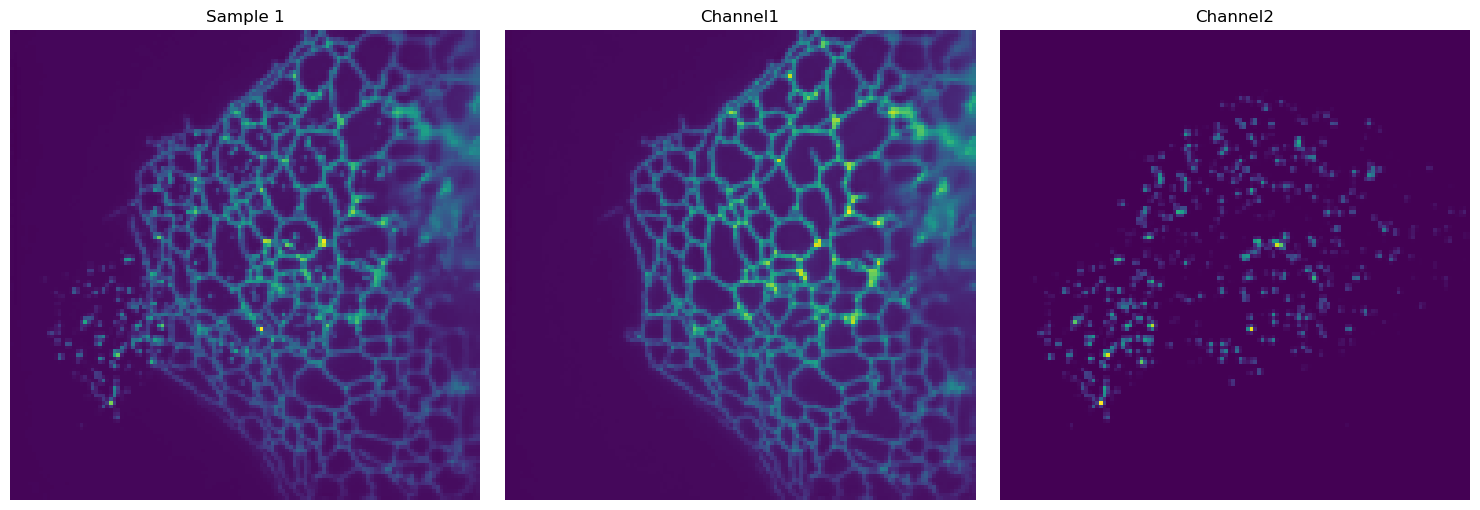

In [5]:
def display_images_in_row(images, titles=None, cmap='viridis'):
    """
    Display a list of images in a row with optional titles.
    
    Args:
        images (list of np.ndarray): List of images to display.
        titles (list of str): List of titles for each subplot (default is None).
        cmap (str): Colormap to use for displaying images (default is 'viridis').
    """
    n_images = len(images)
    
    _, axes = plt.subplots(1, n_images, figsize=(15, 5))  # Create a row of subplots
    
    if titles is None:
        titles = [''] * n_images  # If no titles are provided, use empty strings
    
    for ax, image, title in zip(axes, images, titles):
        # Check if the image is 3D (e.g., for color images or multi-channel images)
        if len(image.shape) == 3 and image.shape[-1] in [3, 4]:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')  # Hide axis
    
    plt.tight_layout()
    plt.show()

# Assuming sample1, sample2, input, and target are your image arrays
images = [sample[0], sample[1][0], sample[1][1]]
titles = ['Sample 1', 'Channel1', 'Channel2']

display_images_in_row(images, titles)


Important: we don't need to create ourselves the patches. The model can handle it.

## Create Model

### Swin2SR

In [6]:
import sys
sys.path.append('..')

In [7]:
from swin2sr.models.network_swin2sr import Swin2SR

In [8]:
# depths = [6, 6, 6, 6]
# num_heads = [6, 6, 6, 6]
depths = [3, 3]
num_heads = [3, 3]

model = Swin2SR(upscale=1, in_chans = 1, img_size=(height, width),
                   window_size=4, img_range=1., depths=depths,
                   embed_dim=60, num_heads=num_heads, mlp_ratio=2, upsampler='pixelshuffledirect')

In [9]:
print(model)

Swin2SR(
  (conv_first): Conv2d(1, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (proj): Conv2d(60, 60, kernel_size=(1, 1), stride=(1, 1))
    (norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=60, input_resolution=(128, 128), depth=3
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=60, input_resolution=(128, 128), num_heads=3, window_size=4, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=60, window_size=(4, 4), pretrained_window_size=(0, 0), num_heads=3
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(i

In [10]:
criterion = torch.nn.MSELoss()

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
num_epochs = 50  
model.cuda()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        
        # Ensure outputs and targets have the same dimensions for loss computation
        if outputs.shape != targets.shape:
            print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
            raise ValueError("Output and target shapes do not match!")
        
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss
    
    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
    # Validation loop (optional but recommended)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.cuda(), targets.cuda()

            # Ensure inputs and targets have the correct dimensions
            if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
                inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
            if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
                targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]

            outputs = model(inputs)  # Forward pass
            
            # Ensure outputs and targets have the same dimensions for loss computation
            if outputs.shape != targets.shape:
                print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
                raise ValueError("Output and target shapes do not match!")
            
            loss = criterion(outputs, targets)  # Compute loss
            val_loss += loss.item()  # Accumulate loss
    
    # Compute average validation loss for the epoch
    val_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'swin2sr_model.pth')


Output shape: torch.Size([4, 1, 128, 128]), Target shape: torch.Size([4, 2, 128, 128])


ValueError: Output and target shapes do not match!